In [1]:
%matplotlib inline
import cv2
import sys
import tensorflow as tf
import numpy as np
import skimage.io as io
import os
from sklearn.model_selection import train_test_split
from math import*
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from scipy.linalg import*
from sympy import*
import math
import scipy.ndimage
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

print (tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Using TensorFlow backend.


2.2.0
Found GPU at: /device:GPU:0
Wed Jul  1 08:36:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |    353MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                      

In [2]:
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/My Drive'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass
sys.path.append(base_working_dir)
!mkdir -p drive
!google-drive-ocamlfuse drive
print(base_working_dir)

base_working_dir = os.path.join(base_working_dir, '3d_heatmap')

if not os.path.exists(base_working_dir):
    os.makedirs(base_working_dir)
    
print (base_working_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/bin/bash: google-drive-ocamlfuse: command not found
/content/drive/My Drive
/content/drive/My Drive/3d_heatmap


# Load Data

In [3]:
data=np.load('/content/drive/My Drive/data35.npz')
coordinates=np.load('/content/drive/My Drive/z35ddl.npy')
name=np.load('/content/drive/My Drive/3d_heatmap/name21.npy')

X=data['ct']
seg=data['seg']

print(X.shape)
print(seg.shape)
print(coordinates.shape)

(35, 136, 128, 144)
(35, 136, 128, 144, 2)
(35, 21, 3)


# Create Heatmap

In [6]:
def gaussian(array_like_hm, mean, sigma):
    """modified version normal distribution pdf, vector version"""
    array_like_hm -= mean
    x_term = array_like_hm[:, 0] ** 2
    y_term = array_like_hm[:, 1] ** 2
    z_term = array_like_hm[:, 2] ** 2
    exp_value = - (x_term + y_term+z_term) / 2 / pow(sigma, 2)
    return np.exp(exp_value)

def draw_heatmap(width, height, depth,x, y,z, sigma, array_like_hm):
    m1 = (x, y,z)
    s1 = np.eye(3) * pow(sigma, 2)
    zz = gaussian(array_like_hm, m1, sigma)
    img = zz.reshape((height, width,depth))
    return img

def test(width, height,depth, x, y,z, array_like_hm):
    sigma=3
    return draw_heatmap(width, height,depth, x, y,z, sigma, array_like_hm)

hr=[]
for j in range(4): 
  h=[]
  for i in range(35):
      xres = 128
      yres = 136
      zres = 144
      xlim = (0, xres)
      ylim = (0, yres)
      zlim = (0, zres)
      x = np.arange(xres, dtype=np.float)
      y = np.arange(yres, dtype=np.float)
      z = np.arange(zres, dtype=np.float)
      xx, yy,zz = np.meshgrid(x, y,z)

      # evaluate kernels at grid points
      xxyyzz = np.c_[xx.ravel(), yy.ravel(),zz.ravel()]

      img = test(xres, yres,zres, coordinates[i,j,1],coordinates[i,j,0],coordinates[i,j,2],xxyyzz.copy())
      # imgr=rot(bs[i],img)
      h.append(img)
  hr.append(h)
hr=np.array(hr)
hr=hr.transpose((1,2,3,4,0))
print(hr.shape)

(35, 136, 128, 144, 4)


# shape check

In [7]:
xr=np.expand_dims(X,axis=4)
print('xr.shape:',xr.shape)
print('hr.shape:',hr.shape)

xr.shape: (35, 136, 128, 144, 1)
hr.shape: (35, 136, 128, 144, 4)


# Data Generator

In [33]:
x_train, x_test, y_train1, y_test1 =train_test_split(xr,seg, test_size=0.085, random_state=666)
x_train, x_test, y_train2, y_test2 =train_test_split(xr,hr, test_size=0.085, random_state=666)
print(x_train.shape,y_train2.shape)

def myGenerator():
    while 1:
        for i in range(32):
          yield x_train[i*1:(i+1)*1], [y_train1[i*1:(i+1)*1],y_train2[i*1:(i+1)*1]]

(32, 136, 128, 144, 1) (32, 136, 128, 144, 4)


# Model

In [34]:
def load_3d_unet(pretrained_weights = None,input_shape=(136,128,144,1), num_labels=4, init_filter=24):
    inputs = Input(shape = input_shape)
    conv1 = ZeroPadding3D((1, 1, 1))(inputs)
    conv1 = Conv3D(init_filter, (3, 3, 3), strides=(1, 1, 1))(conv1)
    conv1 = BatchNormalization(axis = -1)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = ZeroPadding3D((1, 1, 1))(conv1)
    conv1 = Conv3D(init_filter, (3, 3, 3), strides=(1, 1, 1))(conv1)
    conv1 = BatchNormalization(axis = -1)(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = ZeroPadding3D((1, 1, 1))(pool1)
    conv2 = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv2)
    conv2 = BatchNormalization(axis = -1)(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = ZeroPadding3D((1, 1, 1))(conv2)
    conv2 = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv2)
    conv2 = BatchNormalization(axis = -1)(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = ZeroPadding3D((1, 1, 1))(pool2)
    conv3 = Conv3D(init_filter*4, (3, 3, 3), strides=(1, 1, 1))(conv3)
    conv3 = BatchNormalization(axis = -1)(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = ZeroPadding3D((1, 1, 1))(conv3)
    conv3 = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv3)
    conv3 = BatchNormalization(axis = -1)(conv3)
    conv3 = Activation('relu')(conv3)

    up1 = concatenate([UpSampling3D(size=(2, 2, 2))(conv3), conv2], axis=-1)
    conv4 = ZeroPadding3D((1, 1, 1))(up1)
    conv4 = Conv3D(init_filter*4, (3, 3, 3), strides=(1, 1, 1))(conv4)
    conv4 = BatchNormalization(axis = -1)(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = ZeroPadding3D((1, 1, 1))(conv4)
    conv4 = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv4)
    conv4 = BatchNormalization(axis = -1)(conv4)
    conv4 = Activation('relu')(conv4)

    up2 = concatenate([UpSampling3D(size=(2, 2, 2))(conv4), conv1], axis=-1)
    conv5 = ZeroPadding3D((1, 1, 1))(up2)
    conv5 = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv5)
    conv5 = BatchNormalization(axis = -1)(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = ZeroPadding3D((1, 1, 1))(conv5)

    # segment
    conv5s = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv5)
    conv5s = BatchNormalization(axis = -1)(conv5s)
    conv5s = Activation('relu')(conv5s)
    outputs1=Conv3D(2, (1, 1, 1), activation='sigmoid')(conv5s)
    
    #landmark
    conv5l = Conv3D(init_filter*2, (3, 3, 3), strides=(1, 1, 1))(conv5)
    conv5l = BatchNormalization(axis = -1)(conv5l)
    conv5l = Activation('relu')(conv5l)
    dropout = Dropout(0.4)(conv5l)
    outputs2=Conv3D(num_labels, (1, 1, 1), activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=[outputs1,outputs2])
    model.compile(optimizer=Adam(lr=1e-4), loss=['binary_crossentropy','mean_squared_error'],loss_weights=[1,4],metrics=['accuracy'])
    if(pretrained_weights):
      model.load_weights(pretrained_weights)
    return model

In [35]:
model=load_3d_unet(pretrained_weights ='/content/drive/My Drive/segu.hdf5')
es =EarlyStopping(monitor='loss', min_delta=1e-5, patience=200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=50, min_lr=1e-5)
point1 = ModelCheckpoint('/content/drive/My Drive/segu.hdf5', monitor='val_loss',verbose=0, save_best_only=True)

# Training

In [53]:
epochs = 400
history = model.fit_generator(myGenerator(),steps_per_epoch=32,epochs = epochs,verbose=1,validation_data=(x_test,[y_test1,y_test2]),callbacks=[point1,reduce_lr])


In [52]:
# summarize history for loss
plt.plot(history.history['loss'][50:400])
plt.plot(history.history['val_loss'][50:400])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
seg_result,result=model.predict(x_test)
print(result.shape)
print(y_test2.shape)
print(np.where(result[0,:,:,:,1]==np.max(result[0,:,:,:,1])))
print(np.where(y_test2[0,:,:,:,1]==np.max(y_test2[0,:,:,:,1])))

# 定位可视化（e.g. 下巴）





(3, 136, 128, 144, 4)
(3, 136, 128, 144, 1)
(3, 136, 128, 144, 4)


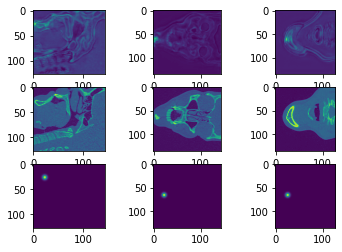

In [39]:
print(result.shape)
print(x_test.shape)
print(y_test2.shape)
plt.subplot(3,3,1)
plt.imshow(result[1,55,:,:,2])
plt.subplot(3,3,2)
plt.imshow(result[1,:,24,:,2])
plt.subplot(3,3,3)
plt.imshow(result[1,:,:,9,2])
plt.subplot(3,3,4)
plt.imshow(x_test[1,55,:,:,0])
plt.subplot(3,3,5)
plt.imshow(x_test[1,:,24,:,0])
plt.subplot(3,3,6)
plt.imshow(x_test[1,:,:,9,0])
plt.subplot(3,3,7)
plt.imshow(y_test2[1,55,:,:,2])
plt.subplot(3,3,8)
plt.imshow(y_test2[1,:,24,:,2])
plt.subplot(3,3,9)
plt.imshow(y_test2[1,:,:,9,2])
plt.show()

In [40]:
result=result.transpose((4,0,1,2,3))
y_test2=y_test2.transpose((4,0,1,2,3))

# Segmentation Evaluation


In [56]:
seg_result[seg_result>0.5]=1
seg_result[seg_result<0.5]=0
seg_error=np.abs(y_test1-seg_result)
error_ratio=np.sum(seg_error)/(3*136*128*144*2)
acc=1-error_ratio
tp=seg_result*y_test1
tp=1-tp

dice=2*np.sum(tp)/(2*np.sum(tp)+np.sum(seg_error))
print("Pixel Accuracy of segmentation is",acc)
print("Dice Coefficient of segmentation is",dice)

Pixel Accuracy of segmentation is 0.9901869534414598
Dice Coefficient of segmentation is 0.889753976184401


# 

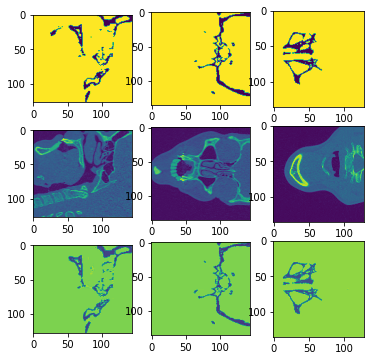

In [59]:
plt.figure(figsize=(6,6))
plt.subplot(3,3,1)
plt.imshow(seg_result[1,68,:,:,1])
plt.subplot(3,3,2)
plt.imshow(seg_result[1,:,64,:,1])
plt.subplot(3,3,3)
plt.imshow(seg_result[1,:,:,72,1])
plt.subplot(3,3,4)
plt.imshow(x_test[1,55,:,:,0])
plt.subplot(3,3,5)
plt.imshow(x_test[1,:,24,:,0])
plt.subplot(3,3,6)
plt.imshow(x_test[1,:,:,9,0])
plt.subplot(3,3,7)
plt.imshow(y_test1[1,68,:,:,1])
plt.subplot(3,3,8)
plt.imshow(y_test1[1,:,64,:,1])
plt.subplot(3,3,9)
plt.imshow(y_test1[1,:,:,72,1])
plt.show()

#Distance Error Evaluation

In [58]:
num_landmarks=int(result.shape[0])
samples=int(result.shape[1])
total=num_landmarks*samples

def euclidean_distance(gt,prediction):
  store=[]
  error=gt-prediction
  for i in range(total):
    distance=np.sqrt(np.sum(np.square(error[i])))
    store.append(distance)
  s=np.array(store)
  return s

gt=[]
for j in range(num_landmarks):
  for i in range(samples):
    landmarks=[int(np.where(y_test2[j,i,:,:]==np.max(y_test2[j,i,:,:]))[0]),int(np.where(y_test2[j,i,:,:]==np.max(y_test2[j,i,:,:]))[1]),int(np.where(y_test2[j,i,:,:]==np.max(y_test2[j,i,:,:]))[2])]
    gt.append(landmarks)
gt=np.array(gt)


#original
predict=[]
for j in range(num_landmarks):
  for i in range(samples):
    landmarks=[int(np.where(result[j,i,:,:]==np.max(result[j,i,:,:]))[0]),int(np.where(result[j,i,:,:]==np.max(result[j,i,:,:]))[1]),int(np.where(result[j,i,:,:]==np.max(result[j,i,:,:]))[2])]
    predict.append(landmarks)
predict=np.array(predict)

error=euclidean_distance(gt,predict)
for i in range(num_landmarks):
  print(name[i],':',round(np.sum(error[samples*i:samples*(i+1)])/samples,2))
r=np.mean(error)
std=np.std(error)
print("distance error for 3d unet is",str(round(r,2)),'±',str(round(std,2)))